In [77]:
from code.fasttext.embedding_utils import TableEncoder, compare_embeddings
from code.utils.settings import DefaultPath
from code.utils.utils import rebuild_table

import pandas as pd
import numpy as np
import polars as pl

import jsonlines

In [78]:
sloth_results = pl.scan_csv(
    source=DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-results-r5-c2-a50.csv'
    ).sort(by=['a%', 'o_a', 'jsim'], descending=[True, True, True])

In [79]:
def retrive_tables_in_jsonl(table_ids:str|list[str],
                           source=DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-tables-r5-c2-a50.jsonl'):
    rv = {}
    table_ids = set(table_ids)
    with jsonlines.open(source) as reader:
        for json_table in reader:
            if json_table['_id'] in table_ids:
                table_ids.remove(json_table['_id'])
                rv[json_table['_id']] = json_table
                if table_ids == set():
                    return rv    
        return rv

In [80]:
sloth_results = sloth_results.collect()
sloth_results.head()

r_id,s_id,jsim,o_a,a%
str,str,f64,i64,f64
"""30210174-4""","""6897174-2""",1.0,2646,1.0
"""13887536-1""","""6516641-4""",1.0,1014,1.0
"""2701625-3""","""2701625-4""",1.0,940,1.0
"""31897527-2""","""4279839-2""",1.0,817,1.0
"""14797628-2""","""14797781-2""",1.0,801,1.0


In [81]:
import itertools

# intervals = [(0, 0.4), (0.4, 0.6), (0.6, 0.85), (0.85, 1)]
intervals = [(0, 0.5), (0.5, 0.75), (0.75, 1)]

classes = list(itertools.product(intervals, repeat=2))

samples_size = 200
samples_ids = []
samples = {}

for (a_lim, jsim_lim) in classes:
    sample = sloth_results.filter(
        (pl.col('a%') >= a_lim[0]) & (pl.col('a%') < a_lim[1]) & \
        (pl.col('jsim') >= jsim_lim[0]) & (pl.col('jsim') < jsim_lim[1])
    )
    sample = sample.sample(min([samples_size, sample.shape[0]]))
    print(a_lim, '\t', jsim_lim, '\t', min([samples_size, sample.shape[0]]))
    samples[(a_lim, jsim_lim)] = sample
    
    samples_ids += [id for row in sample.iter_rows() for id in row[:2]]

(0, 0.5) 	 (0, 0.5) 	 200
(0, 0.5) 	 (0.5, 0.75) 	 200
(0, 0.5) 	 (0.75, 1) 	 200
(0.5, 0.75) 	 (0, 0.5) 	 200
(0.5, 0.75) 	 (0.5, 0.75) 	 200
(0.5, 0.75) 	 (0.75, 1) 	 200
(0.75, 1) 	 (0, 0.5) 	 12
(0.75, 1) 	 (0.5, 0.75) 	 200
(0.75, 1) 	 (0.75, 1) 	 200


In [82]:
jtables = retrive_tables_in_jsonl(samples_ids)
tables = dict(map(lambda r: (r[0], rebuild_table(r[1])), jtables.items()))

In [101]:
metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    metadata.loc[len(metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",200,6098,4121
1,"(0, 0.5)","(0.5, 0.75)",200,6962,3564
2,"(0, 0.5)","(0.75, 1)",200,7709,5266
3,"(0.5, 0.75)","(0, 0.5)",200,9144,1872
4,"(0.5, 0.75)","(0.5, 0.75)",200,8665,2344
5,"(0.5, 0.75)","(0.75, 1)",200,10416,1637
6,"(0.75, 1)","(0, 0.5)",12,525,166
7,"(0.75, 1)","(0.5, 0.75)",200,7556,3235
8,"(0.75, 1)","(0.75, 1)",200,9787,1700


In [102]:
# leverage on #rows
new_samples = {}
row_threshold = 5000

for cls in classes:
    sample = samples[cls]
    new_sample = pl.DataFrame(schema=sample.schema)
    nrows = 0
    for row in sample.iter_rows():
        nrows += tables[row[0]].shape[0] + tables[row[1]].shape[0]
        if nrows > row_threshold:
            break
        new_sample.vstack(pl.DataFrame(dict(zip(sample.columns, row))), in_place=True)
    new_samples[cls] = new_sample

In [103]:
new_metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = new_samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    new_metadata.loc[len(new_metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
new_metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",164,4973,3386
1,"(0, 0.5)","(0.5, 0.75)",141,5000,2603
2,"(0, 0.5)","(0.75, 1)",119,4988,3075
3,"(0.5, 0.75)","(0, 0.5)",104,4953,948
4,"(0.5, 0.75)","(0.5, 0.75)",113,4998,1315
5,"(0.5, 0.75)","(0.75, 1)",97,4797,820
6,"(0.75, 1)","(0, 0.5)",12,525,166
7,"(0.75, 1)","(0.5, 0.75)",124,4996,1981
8,"(0.75, 1)","(0.75, 1)",102,4984,875


In [99]:
TableEncoder.available_models

{'cc.en.300.compressed': '/home/giovanni/unimore/TESI/src/models/fastText/cc.en.300.compressed.bin',
 'ft_cc.en.300_freqprune_400K_100K_pq_300': '/home/giovanni/unimore/TESI/src/models/fastText/ft_cc.en.300_freqprune_400K_100K_pq_300.bin'}

In [100]:
tabenc = TableEncoder('cc.en.300.compressed')

# Working on Rows

## Adding Label - Keeping Numbers

  0%|          | 0/9 [00:00<?, ?it/s]

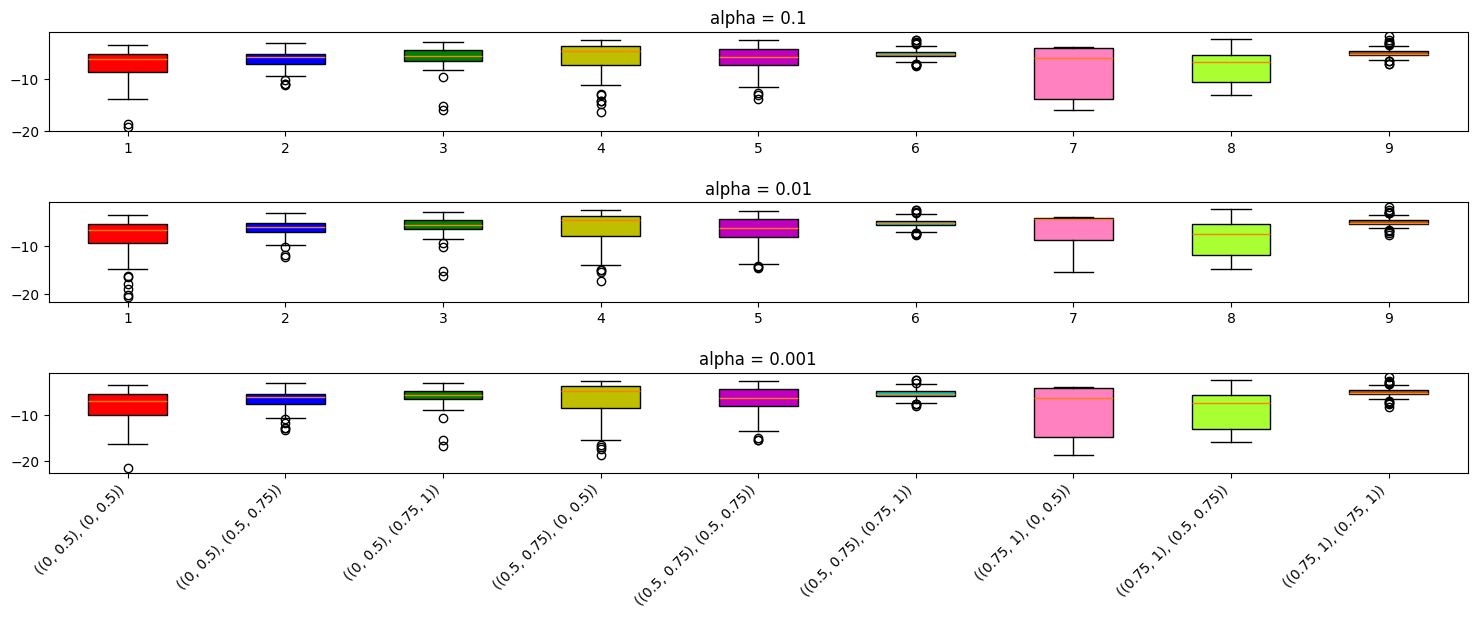

In [104]:
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

alphas = [0.1, 0.01, 0.001]
fig, axis = plt.subplots(len(alphas), 1, figsize=(15, 5))
num_inf = defaultdict(int)

all_logabsdet = defaultdict(list)

for cls in tqdm(classes, total=len(classes)):
    
    # sample = samples[cls]
    sample = new_samples[cls]

    row_logdet = defaultdict(list)
    column_logdet = defaultdict(list)

    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]

        rre, rce = tabenc.full_embedding(rt, True, False)
        sre, sce = tabenc.full_embedding(st, True, False)

        # rows
        rre, sre = (rre, sre) if rre.shape[0] >= sre.shape[0] else (sre, rre)
        ntofill = max(0, rre.shape[0] - sre.shape[0])
        sample_idxs = np.random.choice(sre.shape[0], size=ntofill)
        for alpha in alphas:
            sre_ext = np.concatenate([sre, alpha * sre[sample_idxs]])
            logdet = np.linalg.slogdet(rre @ sre_ext.T)

            if logdet.logabsdet == -np.inf or logdet.logabsdet == np.inf:
                num_inf[alpha] += 1
            else:
                row_logdet[alpha].append(logdet.logabsdet / rre.shape[0])

    for alpha in alphas:
        all_logabsdet[alpha].append(row_logdet[alpha])
    


colors = ['r', 'b', 'g', 'y', 'm', 'c', '#FF81C0', '#AAFF32', '#A9561E']
fig.tight_layout(h_pad=3)

for i, alpha in enumerate(alphas):
    axis[i].set_title(f'alpha = {alpha}')
    
    bplot = axis[i].boxplot(all_logabsdet[alpha], vert=True, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

axis[-1].set_xticks(axis[-1].get_xticks())
axis[-1].set_xticklabels(classes, rotation=45, ha='right')

plt.show()

In [105]:
num_inf

defaultdict(int, {0.1: 89, 0.01: 83, 0.001: 94})

## Adding Labels - Removing Numbers

  0%|          | 0/9 [00:00<?, ?it/s]

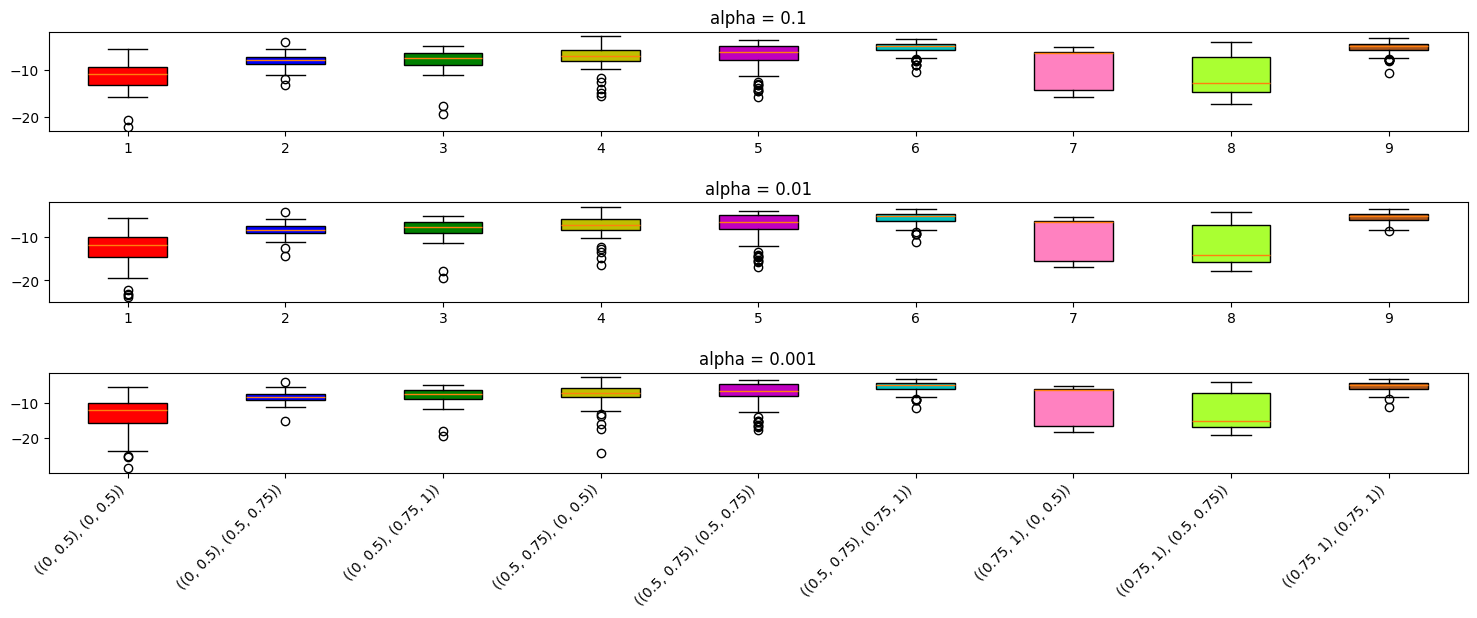

In [96]:
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

alphas = [0.1, 0.01, 0.001]
fig, axis = plt.subplots(len(alphas), 1, figsize=(15, 5))
num_inf = defaultdict(int)

all_logabsdet = defaultdict(list)

for cls in tqdm(classes, total=len(classes)):
    
    # sample = samples[cls]
    sample = new_samples[cls]

    row_logdet = defaultdict(list)
    column_logdet = defaultdict(list)

    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]

        rre, rce = tabenc.full_embedding(rt, True, True)
        sre, sce = tabenc.full_embedding(st, True, True)

        # rows
        rre, sre = (rre, sre) if rre.shape[0] >= sre.shape[0] else (sre, rre)
        ntofill = max(0, rre.shape[0] - sre.shape[0])
        sample_idxs = np.random.choice(sre.shape[0], size=ntofill)
        for alpha in alphas:
            sre_ext = np.concatenate([sre, alpha * sre[sample_idxs]])
            logdet = np.linalg.slogdet(rre @ sre_ext.T)

            if logdet.logabsdet == -np.inf or logdet.logabsdet == np.inf:
                num_inf[alpha] += 1
            else:
                row_logdet[alpha].append(logdet.logabsdet / rre.shape[0])

    for alpha in alphas:
        all_logabsdet[alpha].append(row_logdet[alpha])
    


colors = ['r', 'b', 'g', 'y', 'm', 'c', '#FF81C0', '#AAFF32', '#A9561E']
fig.tight_layout(h_pad=3)

for i, alpha in enumerate(alphas):
    axis[i].set_title(f'alpha = {alpha}')
    
    bplot = axis[i].boxplot(all_logabsdet[alpha], vert=True, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

axis[-1].set_xticks(axis[-1].get_xticks())
axis[-1].set_xticklabels(classes, rotation=45, ha='right')

plt.show()

In [98]:
num_inf

defaultdict(int, {0.1: 285, 0.01: 286, 0.001: 283})

# Working on Columns

In [90]:
metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",200,6098,4121
1,"(0, 0.5)","(0.5, 0.75)",200,6962,3564
2,"(0, 0.5)","(0.75, 1)",200,7709,5266
3,"(0.5, 0.75)","(0, 0.5)",200,9144,1872
4,"(0.5, 0.75)","(0.5, 0.75)",200,8665,2344
5,"(0.5, 0.75)","(0.75, 1)",200,10416,1637
6,"(0.75, 1)","(0, 0.5)",12,525,166
7,"(0.75, 1)","(0.5, 0.75)",200,7556,3235
8,"(0.75, 1)","(0.75, 1)",200,9787,1700


In [91]:
# leverage on #columns
new_samples = {}
colum_threshold = 1500

for cls in classes:
    sample = samples[cls]
    new_sample = pl.DataFrame(schema=sample.schema)
    ncols = 0
    for row in sample.iter_rows():
        ncols += tables[row[0]].shape[1] + tables[row[1]].shape[1]
        if ncols > colum_threshold:
            break
        new_sample.vstack(pl.DataFrame(dict(zip(sample.columns, row))), in_place=True)
    new_samples[cls] = new_sample

In [92]:
new_metadata = pd.DataFrame(columns=['a_lim', 'jsim_lim', 'sample size', '#rows', '#cols'])
for (a_lim, jsim_lim) in classes:
    sample = new_samples[(a_lim, jsim_lim)]
    nrows, ncols = 0, 0
    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]
        nrows += rt.shape[0] + st.shape[0]
        ncols += rt.shape[1] + st.shape[1]
    new_metadata.loc[len(new_metadata)] = [a_lim, jsim_lim, sample.shape[0], nrows, ncols]
new_metadata

,a_lim,jsim_lim,sample size,#rows,#cols
0,"(0, 0.5)","(0, 0.5)",74,2200,1499
1,"(0, 0.5)","(0.5, 0.75)",84,3116,1499
2,"(0, 0.5)","(0.75, 1)",63,2756,1465
3,"(0.5, 0.75)","(0, 0.5)",163,7641,1492
4,"(0.5, 0.75)","(0.5, 0.75)",128,5786,1497
5,"(0.5, 0.75)","(0.75, 1)",180,9321,1498
6,"(0.75, 1)","(0, 0.5)",12,525,166
7,"(0.75, 1)","(0.5, 0.75)",91,3981,1483
8,"(0.75, 1)","(0.75, 1)",175,8452,1499


  0%|          | 0/9 [00:00<?, ?it/s]

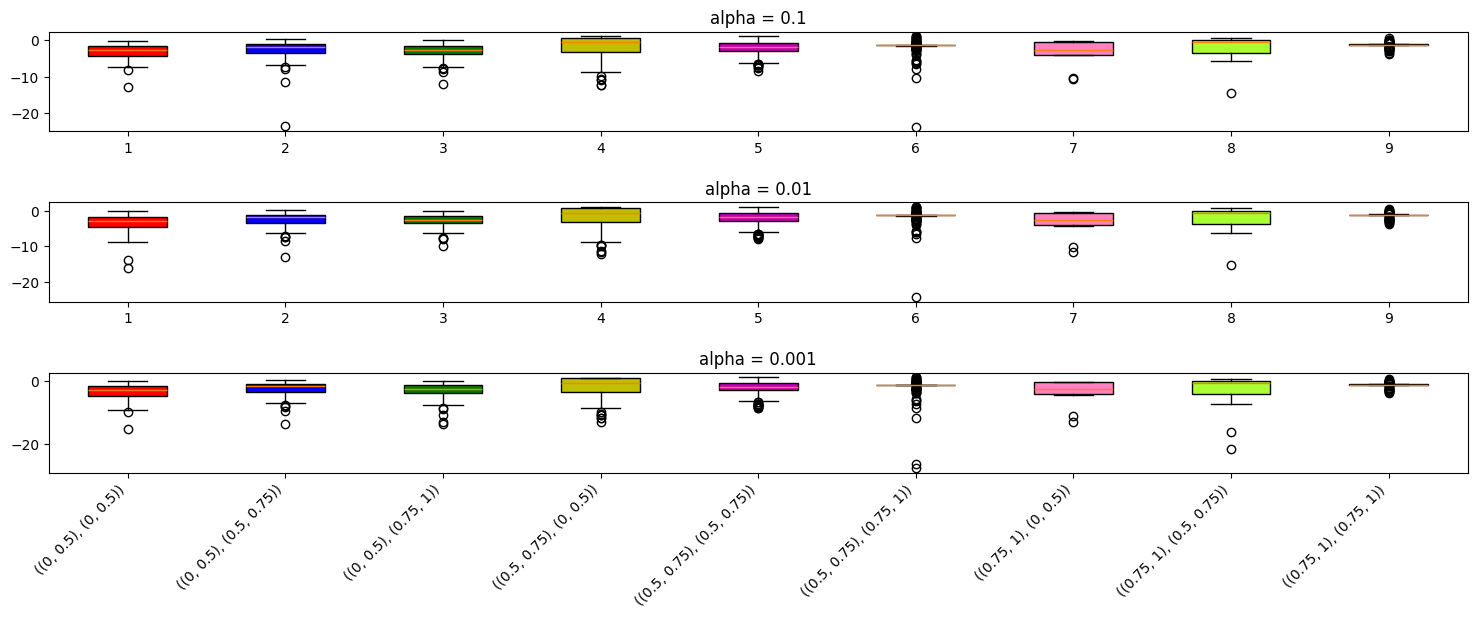

In [94]:
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

alphas = [0.1, 0.01, 0.001]
fig, axis = plt.subplots(len(alphas), 1, figsize=(15, 5))
num_inf = defaultdict(int)

all_logabsdet = defaultdict(list)

for cls in tqdm(classes, total=len(classes)):
    
    # sample = samples[cls]
    sample = new_samples[cls]

    column_logdet = defaultdict(list)

    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]

        rre, rce = tabenc.full_embedding(rt, True, False)
        sre, sce = tabenc.full_embedding(st, True, False)

        # columns
        rce, sce = (rce, sce) if rce.shape[0] >= sce.shape[0] else (sce, rce)
        ntofill = max(0, rce.shape[0] - sce.shape[0])
        sample_idxs = np.random.choice(sce.shape[0], size=ntofill)
        for alpha in alphas:
            sce_ext = np.concatenate([sce, alpha * sce[sample_idxs]])
            logdet = np.linalg.slogdet(rce @ sce_ext.T)

            if logdet.logabsdet == -np.inf or logdet.logabsdet == np.inf:
                num_inf[alpha] += 1
            else:
                column_logdet[alpha].append(logdet.logabsdet / rce.shape[0])

    for alpha in alphas:
        all_logabsdet[alpha].append(column_logdet[alpha])
    


colors = ['r', 'b', 'g', 'y', 'm', 'c', '#FF81C0', '#AAFF32', '#A9561E']
fig.tight_layout(h_pad=3)

for i, alpha in enumerate(alphas):
    axis[i].set_title(f'alpha = {alpha}')
    
    bplot = axis[i].boxplot(all_logabsdet[alpha], vert=True, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

axis[-1].set_xticks(axis[-1].get_xticks())
axis[-1].set_xticklabels(classes, rotation=45, ha='right')

plt.show()

In [ ]:
num_inf

defaultdict(int, {0.1: 61, 0.01: 56, 0.001: 58})

## With Normalization

  0%|          | 0/9 [00:00<?, ?it/s]

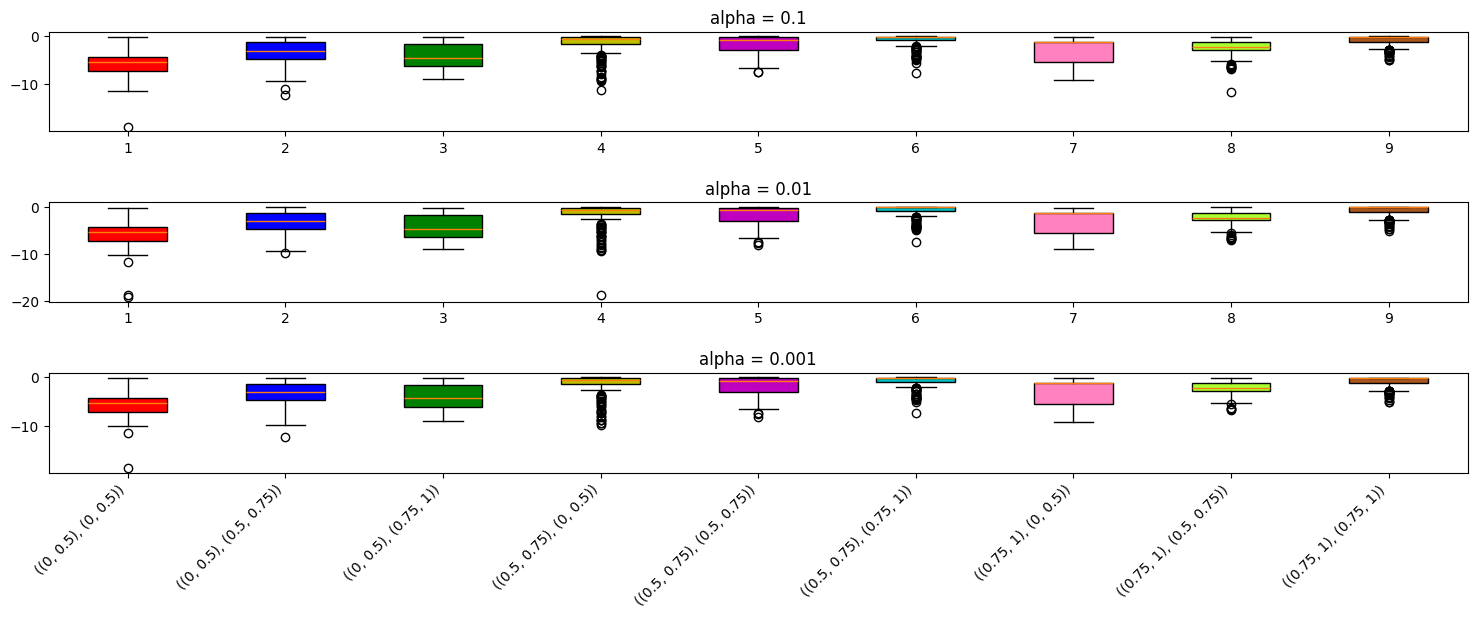

In [ ]:
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

alphas = [0.1, 0.01, 0.001]
fig, axis = plt.subplots(len(alphas), 1, figsize=(15, 5))
num_inf = defaultdict(int)

all_logabsdet = defaultdict(list)

for cls in tqdm(classes, total=len(classes)):
    
    # sample = samples[cls]
    sample = new_samples[cls]

    column_logdet = defaultdict(list)

    for row in sample.iter_rows():
        rt = tables[row[0]]
        st = tables[row[1]]

        rre, rce = tabenc.full_embedding(rt, True, False)
        sre, sce = tabenc.full_embedding(st, True, False)

        # columns
        rce, sce = (rce, sce) if rce.shape[0] >= sce.shape[0] else (sce, rce)
        ntofill = max(0, rce.shape[0] - sce.shape[0])
        sample_idxs = np.random.choice(sce.shape[0], size=ntofill)
        for alpha in alphas:
            sce_ext = np.concatenate([sce, alpha * sce[sample_idxs]])
            logdet = np.linalg.slogdet(normalize(rce, axis=1) @ normalize(sce_ext, axis=1).T)

            if logdet.logabsdet == -np.inf or logdet.logabsdet == np.inf:
                num_inf[alpha] += 1
            else:
                column_logdet[alpha].append(logdet.logabsdet / rce.shape[0])

    for alpha in alphas:
        all_logabsdet[alpha].append(column_logdet[alpha])
    

colors = ['r', 'b', 'g', 'y', 'm', 'c', '#FF81C0', '#AAFF32', '#A9561E']
fig.tight_layout(h_pad=3)

for i, alpha in enumerate(alphas):
    axis[i].set_title(f'alpha = {alpha}')
    
    bplot = axis[i].boxplot(all_logabsdet[alpha], vert=True, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

axis[-1].set_xticks(axis[-1].get_xticks())
axis[-1].set_xticklabels(classes, rotation=45, ha='right')

plt.show()

In [ ]:
num_inf

defaultdict(int, {0.01: 63, 0.1: 64, 0.001: 68})